In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import random

In [ ]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

In [ ]:
%run utils.ipynb

/content/drive/MyDrive/Colab Notebooks


/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks


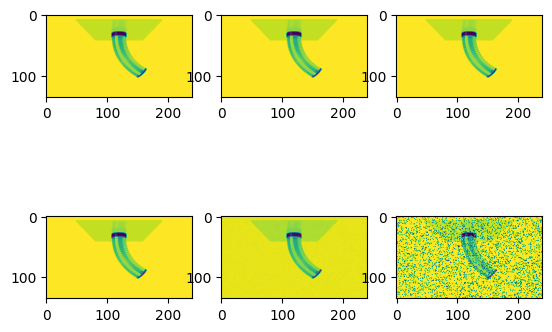

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


(513, 135, 240, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


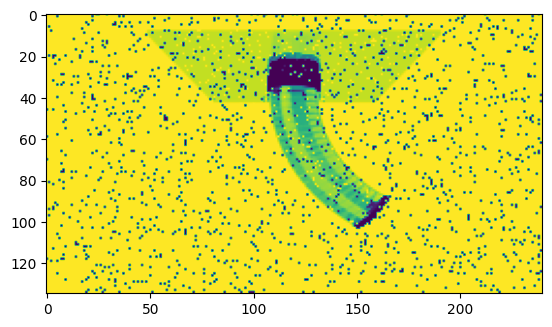

In [ ]:
%run DataAugmentation.ipynb

### Offline Data Augmentation

In [ ]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), \
  (test_images, test_tip_pos) = get_augmented_dataset(
    force_resize=False, rescale_coordinates=100, target_size=(224, 224),
    train_perc=0.6, eval_perc=0.2, test_perc=0.2, **augmentation_configuration,
  )

#### VGG19

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3)                 75267     
                                                                 
Total params: 20,099,651
Trainable params: 75,267
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
print(len(train_images), len(train_tip_pos))

1842 1842


In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
58/58 [==============================] - 15s 88ms/step - loss: 22.1139 - mean_absolute_error: 3.3402 - mean_euclidean_error: 6.7994 - val_loss: 5.1456 - val_mean_absolute_error: 1.5426 - val_mean_euclidean_error: 3.2627
Epoch 2/100
58/58 [==============================] - 3s 59ms/step - loss: 2.5980 - mean_absolute_error: 1.0647 - mean_euclidean_error: 2.2197 - val_loss: 1.8335 - val_mean_absolute_error: 0.8578 - val_mean_euclidean_error: 1.8136
Epoch 3/100
58/58 [==============================] - 4s 62ms/step - loss: 1.2257 - mean_absolute_error: 0.6995 - mean_euclidean_error: 1.4738 - val_loss: 0.9637 - val_mean_absolute_error: 0.5865 - val_mean_euclidean_error: 1.2364
Epoch 4/100
58/58 [==============================] - 4s 64ms/step - loss: 0.8288 - mean_absolute_error: 0.5730 - mean_euclidean_error: 1.2074 - val_loss: 0.7396 - val_mean_absolute_error: 0.5175 - val_mean_euclidean_error: 1.0965
Epoch 5/100
58/58 [==============================] - 4s 61ms/step - loss: 0.64

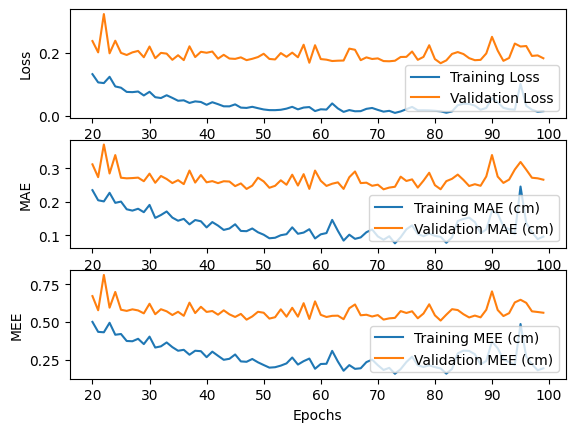

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 0s 48ms/step
103 103 103
103 103 103
x-axis: mean = 0.35603185734226334, std = 1.690981666743524
y-axis: mean = 0.05613398315320739, std = 0.07586456022754534
z-axis: mean = 0.007849818605930346, std = 0.010459988411379635


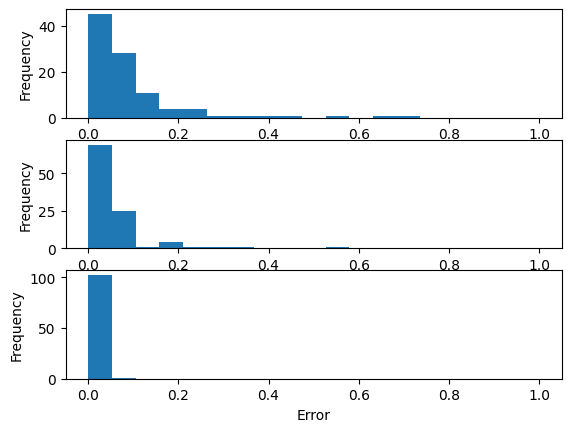

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.2665260136127472
Std of MAE: 0.22955545783042908
Mean of MEE: 0.5614350815250201
Std of MEE: 0.48132268889295515


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.43957619 0.23290609 0.12709579]
Std of Distance along axes: [0.4718476  0.21164592 0.12578119]


In [ ]:
del model

### Online Data Augmentation

#### VGG19

In [ ]:
images, tip_pos = get_dataset(
    target_size=(224, 224),
    force_resize=False, rescale_coordinates=100,
)

(train_images, train_tip_pos), (eval_images, eval_tip_pos), \
  (test_images, test_tip_pos) = holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [ ]:
online_augmentation_configuration = {
    'apply_brightness_change': {'factor': 0.1},
    'apply_saturation_change': {'factor': 1},
    'apply_inversion': {'prob': 0.1},
    'apply_gaussian_noise': {'stddev': 0.1},
    'apply_salt_and_pepper': {'ratio': 0.1}
}
data_augmenter = get_data_augmentation_layer(**online_augmentation_configuration)

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmenter(inputs, training=False)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 20,099,651
Trainable params: 75,267
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 3s 212ms/step - loss: 62.9515 - mean_absolute_error: 6.2846 - mean_euclidean_error: 12.7173 - val_loss: 46.9435 - val_mean_absolute_error: 5.7894 - val_mean_euclidean_error: 11.0490
Epoch 2/100
10/10 [==============================] - 1s 92ms/step - loss: 28.7420 - mean_absolute_error: 4.1751 - mean_euclidean_error: 8.3178 - val_loss: 17.8091 - val_mean_absolute_error: 3.1366 - val_mean_euclidean_error: 6.8423
Epoch 3/100
10/10 [==============================] - 1s 92ms/step - loss: 16.0377 - mean_absolute_error: 3.0516 - mean_euclidean_error: 6.5295 - val_loss: 13.6831 - val_mean_absolute_error: 2.7258 - val_mean_euclidean_error: 5.8330
Epoch 4/100
10/10 [==============================] - 1s 91ms/step - loss: 10.7023 - mean_absolute_error: 2.4020 - mean_euclidean_error: 5.0031 - val_loss: 10.4357 - val_mean_absolute_error: 2.3022 - val_mean_euclidean_error: 4.9303
Epoch 5/100
10/10 [==============================] - 1s 91ms/step - l

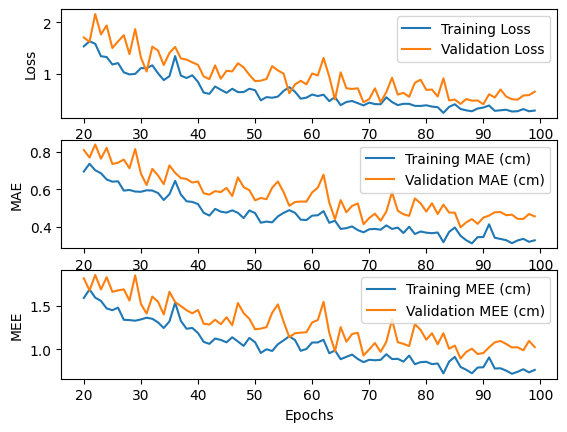

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 1s 50ms/step
103 103 103
103 103 103
x-axis: mean = 0.3462403950901535, std = 0.848912660876824
y-axis: mean = 0.07022158740435734, std = 0.1525590731552432
z-axis: mean = 0.011999607327661147, std = 0.016134297880571715


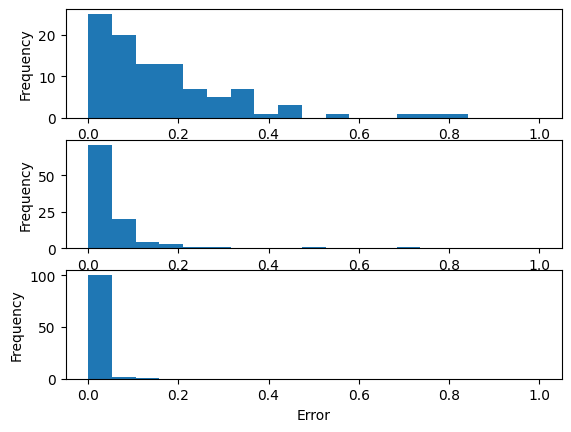

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.4354596436023712
Std of MAE: 0.3057481646537781
Mean of MEE: 0.9810834567848402
Std of MEE: 0.721746574909795


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.86360778 0.24731689 0.19545428]
Std of Distance along axes: [0.74947851 0.1926188  0.19858601]


In [ ]:
del model

#### With a lower learning rate

In [ ]:
images, tip_pos = get_dataset(
    target_size=(224, 224),
    force_resize=False, rescale_coordinates=100,
)

(train_images, train_tip_pos), (eval_images, eval_tip_pos), \
  (test_images, test_tip_pos) = holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [ ]:
online_augmentation_configuration = {
    'apply_brightness_change': {'factor': 0.1},
    'apply_saturation_change': {'factor': 1},
    'apply_inversion': {'prob': 0.1},
    'apply_gaussian_noise': {'stddev': 0.1},
    'apply_salt_and_pepper': {'ratio': 0.1}
}
data_augmenter = get_data_augmentation_layer(**online_augmentation_configuration)

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmenter(inputs, training=False)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 20,099,651
Trainable params: 75,267
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 2s 123ms/step - loss: 78.3315 - mean_absolute_error: 7.2896 - mean_euclidean_error: 14.8014 - val_loss: 34.9366 - val_mean_absolute_error: 4.8670 - val_mean_euclidean_error: 9.8016
Epoch 2/100
10/10 [==============================] - 1s 77ms/step - loss: 31.7290 - mean_absolute_error: 4.5917 - mean_euclidean_error: 9.0589 - val_loss: 37.5530 - val_mean_absolute_error: 5.1171 - val_mean_euclidean_error: 9.7887
Epoch 3/100
10/10 [==============================] - 1s 78ms/step - loss: 24.4330 - mean_absolute_error: 3.9431 - mean_euclidean_error: 7.7948 - val_loss: 20.9987 - val_mean_absolute_error: 3.5584 - val_mean_euclidean_error: 7.3562
Epoch 4/100
10/10 [==============================] - 1s 92ms/step - loss: 16.8783 - mean_absolute_error: 3.0166 - mean_euclidean_error: 6.5855 - val_loss: 18.5673 - val_mean_absolute_error: 3.2747 - val_mean_euclidean_error: 6.9964
Epoch 5/100
10/10 [==============================] - 1s 77ms/step - lo

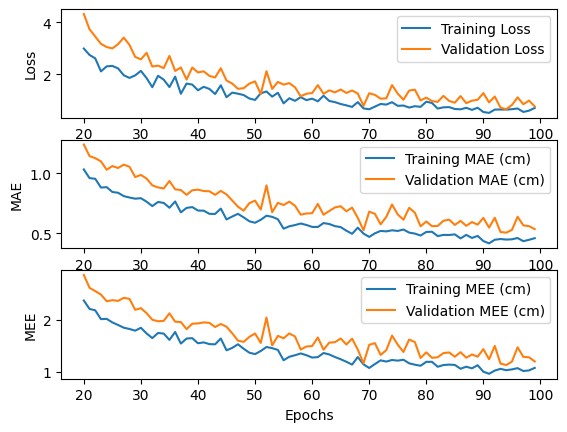

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 0s 45ms/step
103 103 103
103 103 103
x-axis: mean = 0.8258945525605235, std = 3.1313137641974547
y-axis: mean = 0.14220834040485547, std = 0.4877135515605777
z-axis: mean = 0.015124406969550074, std = 0.02419900209747999


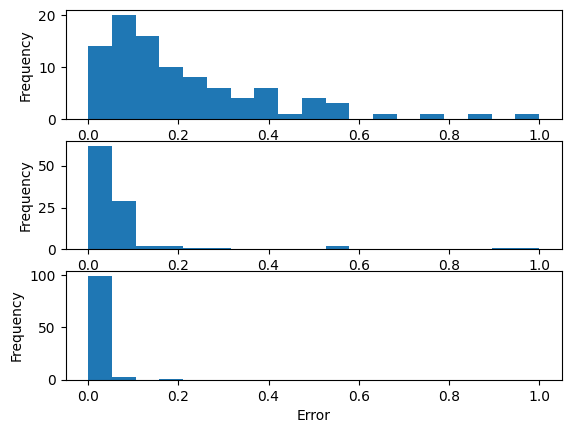

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.586621880531311
Std of MAE: 0.4289747178554535
Mean of MEE: 1.349019427305923
Std of MEE: 1.032158569641964


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [1.22567158 0.29271084 0.24148341]
Std of Distance along axes: [1.05431865 0.23381023 0.26960155]


In [ ]:
del model